In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import turbo_seti.find_event as find
import glob

In [2]:
%matplotlib inline

In [3]:
dat_files = [
    "dat_files/GBT_57523_69379_HIP17147_fine.dat", 
    "dat_files/GBT_57606_50058_HIP20901_fine.dat",
    "dat_files/GBT_57456_02669_HIP39826_fine.dat",
    "dat_files/GBT_57803_80733_HIP4436_fine.dat",  
    "dat_files/GBT_57599_55512_HIP45493_fine.dat", 
    "dat_files/GBT_57459_34297_HIP65352_fine.dat", 
    "dat_files/GBT_57650_54573_HIP66704_fine.dat", 
    "dat_files/GBT_57523_22406_HIP74981_fine.dat", 
    "dat_files/GBT_57680_15520_HIP7981_fine.dat",  
    "dat_files/GBT_57664_79761_HIP82860_fine.dat" 
]

# Demo from website

https://www.geeksforgeeks.org/scipy-stats-histogram-function-python/

No. of points in each bin :  [0 2 4 1]
Size of the bins          :  [0 1 2 3 4]


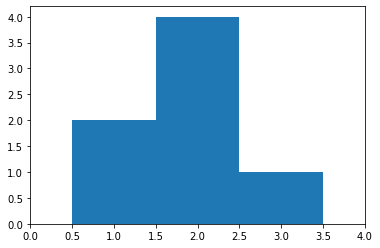

In [4]:
# building the histogram  
import scipy 
import numpy as np  
import matplotlib.pyplot as plt 
  
hist, bin_edges = np.histogram([1, 1, 2, 2, 2, 2, 3], 
                                       bins = range(5)) 
  
# Checking the results 
print ("No. of points in each bin : ", hist) 
print ("Size of the bins          : ", bin_edges) 
  
# plotting the histogram 
plt.bar(bin_edges[:-1], hist, width = 1) 
plt.xlim(min(bin_edges), max(bin_edges)) 
plt.show() 

In [5]:
def calculate_hist(dat_file, bin_width=1): 
    """calculates a histogram of the number of hits for a single .dat file"""
    #read the file into a pandas dataframe
    tbl = find.read_dat(dat_file)

    #make the bins for the histogram
    min_freq = int(min(tbl["Freq"]))
    max_freq = np.round(max(tbl["Freq"]))
    bins = np.arange(min_freq, max_freq, bin_width)
    hist, bin_edges = np.histogram(tbl["Freq"], bins=bins)
    return hist, bin_edges

In [6]:
def calculate_proportion(file_list, bin_width=1, GBT=False):
    """Takes in a list of .dat files and makes a true/false table of hits in a frequency bin"""
    edges = []
    histograms = []
    min_freq = 0
    max_freq = 1e9
    
    #calculate histogram for the .dat file and check the boundaries on the data
    for file in file_list:
        hist, bin_edges = calculate_hist(file, bin_width)
        if min(bin_edges) > min_freq:
            min_freq = min(bin_edges)
        if max(bin_edges) < max_freq:
            max_freq = max(bin_edges)
        edges.append(bin_edges)
        histograms.append(hist)
    
    #make sure all lists are within the boundaries
    for i in range(len(edges)):
        within_boundaries = np.where( (edges[i] >= min_freq) & (edges[i] <= max_freq) ) #get the boundaries of the tightest frequency range
        edges[i] = edges[i][within_boundaries] # take only the entries within that range
        freq_boundaries = within_boundaries[0][:-1] # since the bins list has one more entry than frequencies, I will drop the last entry. the hit count will correspond with the frequency at the start of its bin
        histograms[i] = histograms[i][freq_boundaries] # take only the entries within that range
        
    #create the dataframe and add the frequency bins to column 0
    df = pd.DataFrame()
    df.insert(0, "freq", edges[0][:-1])
    
    #check if there is a hit in the frequency bin and insert value to dataframe
    for i in range(len(histograms)):
        colname = "file"+str(i)
        found_hit = histograms[i] > 0
        df.insert(len(df.columns), colname, found_hit.astype(int))
    
    #exclude entries in the GBT data due to the notch filter exclusion
    bin_edges = np.arange(min_freq, max_freq+.1, bin_width)
    if GBT:
        #still in progress and not ready yet
        df = df[(df["freq"] < 1200) | (df["freq"] > 1341)]
        first_edge = np.arange(min_freq, 1200, bin_width)
        second_edge= np.arange(1341, max_freq, bin_width) #may or may not need max_freq+1
        bin_edges = np.append(first_edge, second_edge)
    
        
    # sum up the number of entries that have a hit and divide by the number of .dat files
    data_labels = df.columns[2:]
    total = df["file0"]
    for label in data_labels:
        total = total + df[label]
    
    return bin_edges, total/len(file_list) 

In [7]:
#pd.set_option('max_rows', None)
#pd.reset_option('max_rows')

In [16]:
a,b = calculate_hist(dat_files[4], bin_width=.1)
len(a), len(b)

(9009, 9010)

In [10]:
bin_edges, prob_hist = calculate_proportion(dat_files, bin_width=.1, GBT=True)
len(bin_edges), len(prob_hist)

ValueError: Length of values does not match length of index

In [11]:
%debug

> /opt/conda/lib/python3.7/site-packages/pandas/core/internals/construction.py(611)sanitize_index()
    609 
    610     if len(data) != len(index):
--> 611         raise ValueError("Length of values does not match length of index")
    612 
    613     if isinstance(data, ABCIndexClass) and not copy:



ipdb>  up


> /opt/conda/lib/python3.7/site-packages/pandas/core/frame.py(3636)_sanitize_column()
   3634 
   3635             # turn me into an ndarray
-> 3636             value = sanitize_index(value, self.index, copy=False)
   3637             if not isinstance(value, (np.ndarray, Index)):
   3638                 if isinstance(value, list) and len(value) > 0:



ipdb>  up


> /opt/conda/lib/python3.7/site-packages/pandas/core/frame.py(3495)insert()
   3493         """
   3494         self._ensure_valid_index(value)
-> 3495         value = self._sanitize_column(column, value, broadcast=False)
   3496         self._data.insert(loc, column, value, allow_duplicates=allow_duplicates)
   3497 



ipdb>  up


> <ipython-input-6-69814f8c6402>(33)calculate_proportion()
     31         colname = "file"+str(i)
     32         found_hit = histograms[i] > 0
---> 33         df.insert(len(df.columns), colname, found_hit.astype(int))
     34 
     35     #exclude entries in the GBT data due to the notch filter exclusion



ipdb>  len(df["freq"])


7478


ipdb>  len(found_hit)


7479


ipdb>  df


        freq  file0  file1
0     1127.1      0      0
1     1127.2      0      0
2     1127.3      0      0
3     1127.4      0      0
4     1127.5      1      0
...      ...    ...    ...
7473  1874.4      0      0
7474  1874.5      0      0
7475  1874.6      0      0
7476  1874.7      0      0
7477  1874.8      0      0

[7478 rows x 3 columns]


ipdb>  exit


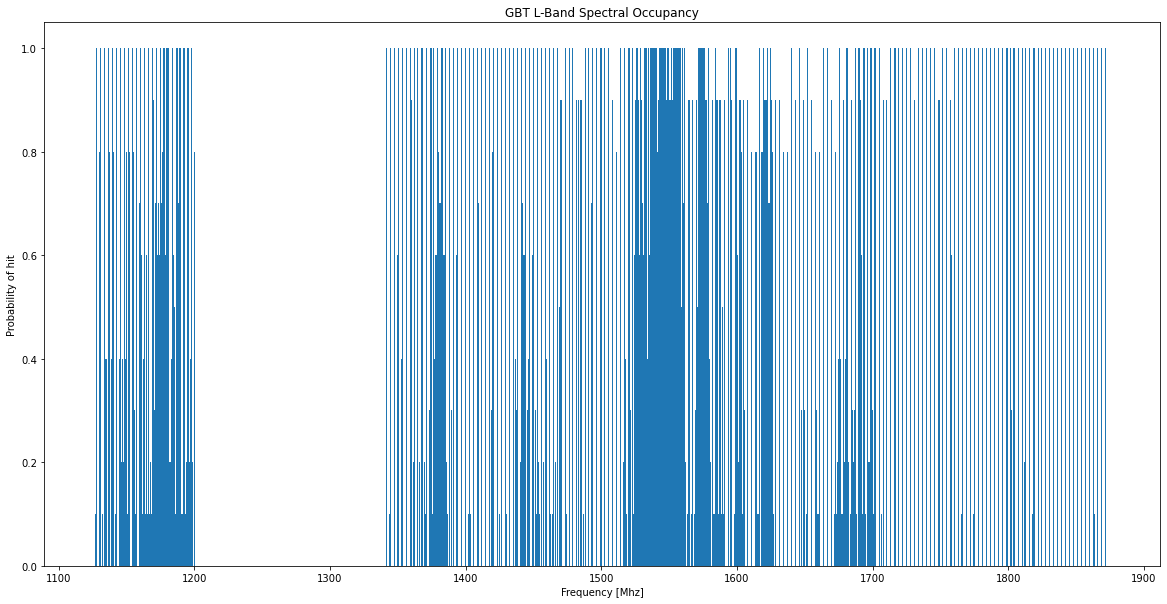

In [88]:
plt.figure(figsize=(20, 10))
plt.bar(bin_edges[:-1], prob_hist)#, width = 1) 
plt.xlabel("Frequency [Mhz]")
plt.ylabel("Probability of hit")
plt.title("GBT L-Band Spectral Occupancy")
#plt.savefig("Spectral_Occupancy_quarter_Mhz_bin.png")

One potential issue with just checking if there is a hit in a bin and marking it as true, regardless of how many hits there are, is that there are bins with 1-2 hits and these are regarded the same as bins that have hits in the hundreds. 

It would be interesting to see if there is a way to account for how many hits there are in the bin. 

Or this could be resolved with adding more than 3 files to my dataset. 

In [14]:
more_data = glob.glob("full_lband/*.dat")

In [36]:
#more_bin_edges, more_prob_hist = calculate_proportion(more_data[:10])
more_bin_edges, more_prob_hist = calculate_proportion(more_data[16:28])

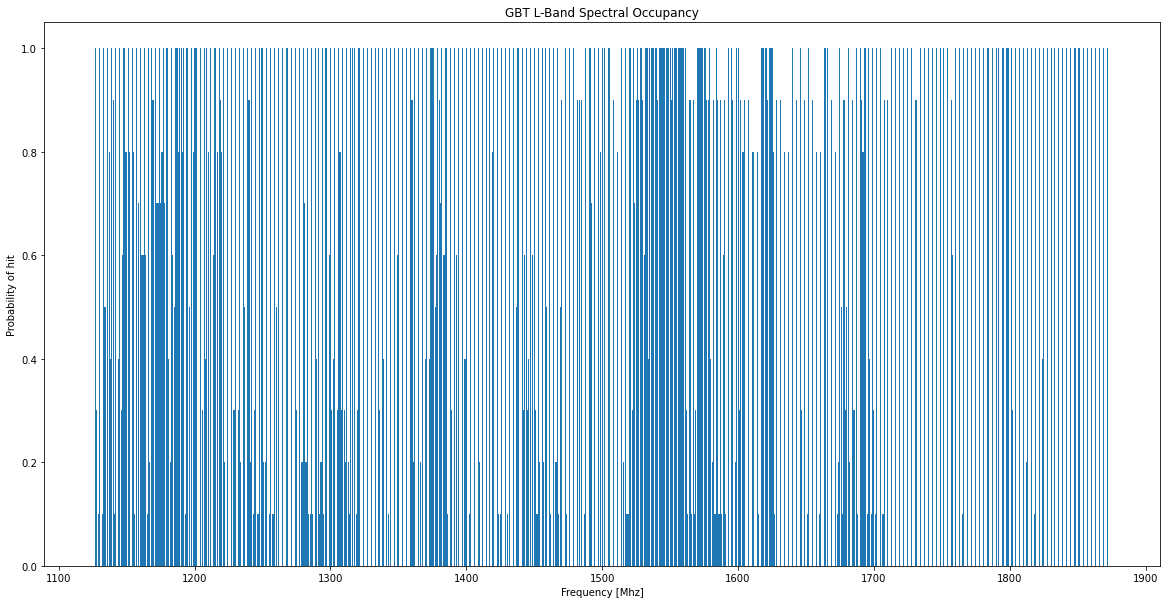

In [37]:
plt.figure(figsize=(20, 10))
plt.bar(bin_edges[:-1], prob_hist)#, width = 1) 
plt.xlabel("Frequency [Mhz]")
plt.ylabel("Probability of hit")
plt.title("GBT L-Band Spectral Occupancy")
plt.show()